# Lab 2: Zillow Dataset Classification and Regression Prediction Models
MSDS 7331 Data Mining - Section 403 - Lab 2

Team: Ivelin Angelov, Yao Yao, Kaitlin Kirasich, Albert Asuncion

<a id="top"></a>
# Contents
* <a href="#Imports">Imports</a>
* <a href="#Define">Define and Prepare Class Variables</a>
    - <a href="#define_c">Classification Variables</a>
    - <a href="#define_r">Regression Variables</a>

* <a href="#Describe">Describe the Final Dataset</a>
    - <a href="#describe_c">Classification Dataset</a>
    - <a href="#describe_r">Regression Dataset</a>

* <a href="#Evaluation">Explain Evaluation Metrics</a>
    - <a href="#metrcs_c">Classification Metrics</a>
    - <a href="#metrcs_r">Regression Metrics</a>
    
* <a href="#Splits">Training and Testing Splits</a>
    - <a href="#splits_c">For Classification</a>
    - <a href="#splits_r">For Regression</a>
    
* <a href="#Models">Three Different Classification/Regression Models</a>
    - <a href="#Classification_m">Classification Models</a>
        - <a href="#KNN_c_m">K Nearest Neighbors</a>
        - <a href="#RandomForest_c_m">Random Forest</a>
        - <a href="#NaiveBayes_c_m">Naive Bayes</a>
    - <a href="#Regression_m">Regression Models</a>
        - <a href="#KNN_r_m">K Nearest Neighbors</a>
        - <a href="#RandomForest_r_m">Random Forest</a>
        - <a href="#GaussianProcess_r_m">Gaussian Regression</a>

* <a href="#Analysis">Visualizations of Results and Analysis</a>
    - <a href="#Classification_a">Analysis of Classification Models</a>
        - <a href="#KNN_c_a">Analysis of K Nearest Neighbors</a>
        - <a href="#RandomForest_c_a">Analysis of  Forest</a>
        - <a href="#NaiveBayes_c_a">Analysis of Naive Bayes</a>
    - <a href="#Regression_a">Regression Models</a>
        - <a href="#KNN_r_a">Analysis of K Nearest Neighbors</a>
        - <a href="#RandomForest_r_a">Analysis of Random Forest</a>
        - <a href="#GaussianProcess_r_a">Analysis of Gaussian Regression</a>

* <a href="#Advantages">Advantages of Each Model</a>
    - <a href="#advantages_c">Classification Models</a>
    - <a href="#advantages_r">Regression Models</a>
        
* <a href="#Attributes">Important Attributes</a>
    - <a href="#attributes_c">Classification Models</a>
    - <a href="#attributes_r">Regression Models</a>
    
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>
    - Feature Elimination
    - Two dimensional Linear Discriminant Analysis
* <a href="#References">References</a>
________________________________________________________________________________________________________
<a id="Imports"></a>
# Imports & Custom Functions
We chose to use the same Zillow dataset from Lab 1 for this exploration in regression and classification. For the origin and purpose of dataset as well as a detailed description of the dataset, refer to https://github.com/post2web/data_mining_group_project/blob/master/notebooks/lab1.ipynb. 

The function `output_variables_table` shows if the variable is nominal or ordinal for further use on classification or regression. The functions `per_class_accuracy` and `confusion_matrix` show the confusion table for correctly and incorrectly identified classification prediction results. The function `plot_class_acc shows` the visual accuracies of classification. The function `plot_feature_importance` shows the feature importance of classification values. The function `print_accuracy` shows the accuracy scores of the classification models. The function `get_dataset_subset` obtains a subset of the full dataset for modeling and prediction.

We will be using a seed of 0. Due to our dataset being extremely large, we are using 5 folds for the CPU usage and runtime to be more managable to run through the prediction models for both classification and regression.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

import warnings
warnings.filterwarnings("ignore")


def output_variables_table(variables):
    variables = variables.sort_index()
    rows = ['<tr><th>Variable</th><th>Type</th><th>Scale</th><th>Description</th></tr>']
    for vname, atts in variables.iterrows():
        if vname not in dataset.columns:
            continue
        atts = atts.to_dict()
        # add scale if TBD
        if atts['scale'] == 'TBD':
            if atts['type'] in ['nominal', 'ordinal']:
                uniques = dataset[vname].unique()
                uniques = list(uniques.astype(str))
                if len(uniques) < 10:
                    atts['scale'] = '[%s]' % ', '.join(uniques)
                else:
                    atts['scale'] = '[%s]' % (', '.join(uniques[:5]) + ', ... (%d More)' % len(uniques))
            if atts['type'] in ['ratio', 'interval']:
                atts['scale'] = '(%d, %d)' % (dataset[vname].min(), dataset[vname].max())
        row = (vname, atts['type'], atts['scale'], atts['description'])
        rows.append('<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>' % row)
    return HTML('<table>%s</table>' % ''.join(rows))


# Define an accuracy plot
def per_class_accuracy(ytrue, yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue, yhat, classes, title=''):
    acc_list = per_class_accuracy(y, yhat)
    pd.DataFrame(acc_list, index=pd.Index(classes, name='Classes')).plot(kind='bar')
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
# Plot the feature importances of the forest
def plot_feature_importance(ytrue, yhat, rt, title=''):
    importances = rt.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rt.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
def print_accuracy(model_name, y_test, yhat, scores):
    scores = np.array(scores)
    
    print('----------------- %s Evaluation -----------------' % model_name)
    print(" F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print(' Accuracy', mt.accuracy_score(y_test, yhat))
    print(' Precision', mt.precision_score(y_test, yhat, average='weighted'))
    print(' Recall', mt.recall_score(y_test, yhat, average='weighted'))
    
def confusion_matrix(ytrue, yhat, classes):
    index = pd.MultiIndex.from_product([['True Class'], classes])
    columns = pd.MultiIndex.from_product([['Predicted Class'], classes])
    return pd.DataFrame(mt.confusion_matrix(y, yhat), index=index, columns=columns)

def roc_curve(ytrue, yhat, clf):
    for i, label in enumerate(clf.classes_):
        fpr, tpr, _ = mt.roc_curve(y, yhat_score[:, i], pos_label=label)
        roc_auc = mt.auc(fpr, tpr)

        plt.plot(fpr, tpr, label='class {0} with {1} instances (area = {2:0.2f})'
                                       ''.format(label, sum(y==label), roc_auc))

        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    plt.show()

    
def get_dataset_subset(dataset, n=1000):
    return {
        'X': dataset['X'].iloc[:n],
        'y': dataset['y'].iloc[:n]
    }


seed = 0
n_splits = 5

<a id="Define"></a>
# Define and Prepare Class Variables
<b>10 points</b>

<i>
<b>Description:</b><br/>
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
</i>

<a href="#top">⏫ Back to Top</a>

<a id="define_c"></a>
## Classification Datasets:

The classification dataset removes `logerror` and `transactiondate` because they were for the purposes of the Kaggle competition and were not complete for the training set. The column that was created for "New Features" from Lab 1 (`city` and `pricepersqft`) were also removed for the sake of simplicity of only using original data for the prediction process. The table generated shows the type of data used for classification purposes.

<a href="#top">⏫ Back to Top</a>

In [2]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']


# delete all location information because we want to predict the couty
# and those feature will give it up to easy
y = dataset['regionidcounty'].copy()
del dataset['regionidcounty']
del dataset['regionidcity']
del dataset['regionidzip']
del dataset['regionidneighborhood']
del dataset['rawcensustractandblock']
del dataset['latitude']
del dataset['longitude']

output_variables = output_variables_table(variables)

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1, random_state=seed)

X = dataset
dataset_class = {
    'X': X,
    'y': y
}
print('Dataset shape:', X.shape)
print(y.groupby(y).size())
output_variables

Dataset shape: (116761, 2105)
regionidcounty
1286    35417
2061    10261
3101    71083
dtype: int64


Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[0, 1, 5, 13, 11, 9, 3]",Type of cooling system present in the home (if any)
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[3, 2, 4, 5, 6, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[7, 4, 10, 1, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
censustractandblock,nominal,"[61110023618600.0, 61110015230000.0, 61110006841300.0, 61110052978700.0, 61110040395800.0, ... (445 More)]",Census tract and block ID combined - also contains blockgroup assignment by extension
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home


<a id="define_r"></a>
## Regression Datasets:

The regression dataset removes `logerror` and `transactiondate` because they were for the purposes of the Kaggle competition and were not complete for the training set. The column that was created for "New Features" from Lab 1 (`city` and `pricepersqft`) were also removed for the sake of simplicity of only using original data for the prediction process. We are only using nominal and continuous data types for regression purposes.

<a href="#top">⏫ Back to Top</a>

Dataset shape: (116761, 2106)


Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[0, 1, 5, 13, 11, 9, 3]",Type of cooling system present in the home (if any)
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[3, 2, 4, 5, 6, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[7, 4, 10, 1, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
censustractandblock,nominal,"[61110023618600.0, 61110015230000.0, 61110006841300.0, 61110052978700.0, 61110040395800.0, ... (445 More)]",Census tract and block ID combined - also contains blockgroup assignment by extension
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home


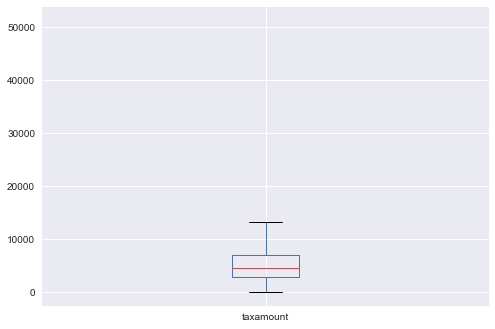

In [3]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']

output_variables = output_variables_table(variables)

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1, random_state=seed)

X = dataset
y = X['taxamount'].copy()
del X['taxamount']
del X['price_per_sqft']

dataset_reg = {
    'X': X,
    'y': y
}
print('Dataset shape:', X.shape)
y.plot(kind='box')
output_variables

<a id="Describe"></a>
# Describe the Final Dataset
<b>5 points</b>

<i>
<b>Description:</b><br/>
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
</i>

<a href="#top">⏫ Back to Top</a>

<a id="describe_c"></a>
## Classification Datasets:

<a href="#top">⏫ Back to Top</a>

Since we are using the same Zillow dataset that we used in the previous lab, most of the data was already cleaned up.  However, the purpose of our classification dataset is to predict the county each property is located in. Therefore our final model removed all columns relating to location such as `latitude`, `longitude`, `city`, and `zipcode`.  We also removed variables we did not need such as `logerror`, `transactiondate`, `and price_per_sqft`.

We did not create any new columns for the classification dataset but we did categorical variable into indicator variables.

The final shape of our classification dataset is 116761 instances and 2105 columns.  The three counties we are trying to predict have sizes of about 35k, 10k, and 71k so an accuracy below 0.61 will mean that we are better off classifying each with the latter county.

<a id="describe_r"></a>
## Regression Datasets:

The regression dataset removes logerror and transactiondate because they were for the purposes of the Kaggle competition and were not complete for the training set. The column that was created for "New Features" from Lab 1 (`city` and `price_per_sqft`) were also removed for the sake of simplicity of only using original data for the prediction process.

We are only using nominal and continuous data types for regression purposes. The final shape of our classification dataset is 116761 instances and 2106 columns. The varaiable that we are predicting, `taxamount`, is right skewed, with outlier property costing more than the standard deviation.

<a href="#top">⏫ Back to Top</a>

<a id="Evaluation"></a>
# Explain Evaluation Metrics
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</i>

<a href="#top">⏫ Back to Top</a>

<a id="metrcs_c"></a>
## Classification Metrics:

<a href="#top">⏫ Back to Top</a>

For our evaluation, we will be taking into account the accuracy and F-measure.  In order to compute the F-measure, we will need the precision and recall.  Because F-measure is a weighted average of these, we think a better F-measure score means the model has a better precision and recall.

Accuracy is the ratio of correct predictions to the total number of observations. It is calculated as: (TP+TN) / (TP+FP+FN+TN). The closer accuracy is to 1, the more accurate the model is, with one caveat. For high accuracy to be a reliable indicator, the dataset has to be symmetric, i.e. total false positives are about equal to false negatives. Otherwise, we need to review other parameters as well.

Precision is the ratio of correctly predicted positive observations to the total positive observations. It is calculated as: TP / (TP+FP).  

Recall is the ratio of correctly predicted positive observations to all actual positives. It is calculated as TP / (TP+FN). The consequences of type 2 errors, predicting a false negative, are not extreme so we think recall is an appropriate measure of completeness.

Finally, we will also use F-measure which is essentially a weighted average of the precision and recall into one simple statistic. F-measure This will be a number between 0 and 1 where closer to 1 is better and approaching 0 is worse. It overcomes the limitations of accuracy whenever false positives and false negatives are not about equal or symmetric.

<a id="metrcs_r"></a>
## Regression Metrics:

For our evaluation of regression prediction models, we are looking at mean squared error (MSE) and R^2. With the large data size and right skew of taxamount, we are trying to minimize MSE and have a R^2 value close to 1. Whichever model with optimal parameters that could reduce MSE and increase R^2 while using less CPU and less runtime would be the best regression model to use for the prediction of the dataset.

<a href="#top">⏫ Back to Top</a>

<a id="Splits"></a>
# Training and Testing Splits
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</i>

Due to our dataset being extremely large, we are using 5 folds for the CPU usage and runtime to be more managable to run through the prediction models for both classification and regression.

<a href="#top">⏫ Back to Top</a>

### Chart of train size while accuracy continues to increase

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

X = dataset_class['X']
y = dataset_class['y']
X, X_test, y, y_test = train_test_split(X, y, test_size=.1, random_state=0)

result = []

# uniform distribution values between 0 and 1
np.random.seed(seed)
mask = np.random.rand(len(X))

for frac in np.linspace(.01, 1, 20):
    mask_frac = mask<=frac
    X_frac = X[mask_frac]
    y_frac = y[mask_frac]

    clf = RandomForestClassifier(max_depth=200, n_estimators=40, random_state=seed)
    clf.fit(X_frac, y_frac)
    y_hat = clf.predict(X_test)
    
    result.append({
        'f1_score': mt.f1_score(y_test, y_hat, average='weighted'),
        'count': len(X_frac),
        'frac': frac
    })

pd.DataFrame(result).plot('count', 'f1_score')

KeyboardInterrupt: 

<a id="splits_c"></a>
## Classification Splits:

<a href="#top">⏫ Back to Top</a>

For the classification task we choose to use Stratified K-Fold cross validation with 5 folds.  We chose stratified in order to preserve the percentage of samples in each class.  We also had a very large dataset so splitting into more than 5 folds would have been computationally expensive with not a large enough return on value.  We felt that splitting the data into 5 folds would be enough splits to reduce the weight of any outliers or noise.


<a id="splits_r"></a>
## Regression Splits:

<a href="#top">⏫ Back to Top</a>

For the regression task we choose to use K-Fold cross validation with 5 folds. We chose K-Fold in order to preserve the percentage of samples in each class. We also had a very large dataset so splitting into more than 5 folds would have been computationally expensive with not a large enough return on value. We felt that splitting the data into 5 folds would be enough splits to reduce the weight of any outliers or noise.

<a id="Models"></a>
# Three Different Classification/Regression Models
<b>20 points</b>

<i>
<b>Description:</b><br/>
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</i>

<a href="#top">⏫ Back to Top</a>

<a id="Classification_m"></a>
## Classification Models:

<a href="#top">⏫ Back to Top</a>

<a id="KNN_c_m"></a>
### Definition and optimization of K Nearest Neighbors (KD Tree) 

K Nearest Neighbors is for the prediction of values based on training their nearest neighbors by a certain n_neighbors count in order to form classification models to predict the y_hat for the test set.

# TODO: fill in once final optimal parameters are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, SparsePCA
from sklearn.gaussian_process import GaussianProcessClassifier

X = dataset_class['X']
y = dataset_class['y']

result = []
scores = []

for n_neighbors in range(2, 30)[::5]:
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
    for train_index, test_index in cv.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # in order to reduce the time for training KNeighborsClassifier
        # we reduce the dimetions of the data from 1717 to 100 and we use kd_tree algorithm
        pca = PCA(n_components=100, random_state=seed)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

        clf = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='kd_tree', weights='distance')
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    f1_score = mt.f1_score(y, yhat, average='weighted')
    print ('n_neighbors:', n_neighbors, ', f1_score:', f1_score)

<a id="RandomForest_c_m"></a>
### Definition and optimization of Random Forest

Random forest is for the prediction of values based on training decision trees by by a certain max depth in order to form classification models to predict the y_hat for the test set.

# TODO: fill in once final optimal parameters are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = dataset_class['X']
y = dataset_class['y']

result = []
index = []
for max_depth in range(1, 401)[::50]:
    yhat = np.zeros(y.shape, dtype=int) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
    for train_index, test_index in cv.split(X, y):
        clf = RandomForestClassifier(max_depth=max_depth, random_state=seed, n_estimators=40)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    f1_score = mt.f1_score(y, yhat, average='weighted')
    print ('max_depth:', max_depth, 'F1 score:', f1_score)
    result.append(f1_score)
    index.append(max_depth)

plt.title('F1 score for different max_depth')
pd.Series(result, index=pd.Index(index, name='max_depth'), name='f1_score').plot();

<a id="NaiveBayes_c_m"></a>
### Definition and optimization of  Naive Bayes (Gaussian)

The Naive Bayes doesn't have any paramethers to optimize and uses maximum likelihood training to classify and predict for the test set.

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.naive_bayes import GaussianNB


X = dataset_class['X']
y = dataset_class['y']


yhat = np.zeros(y.shape) # we will fill this with predictions
cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
scores = []

for train_index, test_index in cv.split(X, y):
    clf = GaussianNB()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    
    f1_score = mt.f1_score(y_test, clf.predict(X_test), average='weighted')
    scores.append(f1_score)

scores = np.array(scores)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('MultinomialNB', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

<a id="Classification_m"></a>
## Definition and optimization of  Regression models:

<a href="#top">⏫ Back to Top</a>

<a id="KNN_r_m"></a>
## Definition and optimization of K Nearest Neighbors

K Nearest Neighbors is for the prediction of values based on training their nearest neighbors by a certain n_neighbors and leaf_size count in order to form regression models to predict the y_hat for the test set.

# TODO: fill in once final optimal parameters are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

yhat = np.zeros(y.shape)
cv = KFold(n_splits=10, random_state=0)
n_neighbors_result = []
leaf_size_result = []

for n_neighbors in [1,2,3,4,5,6]:
    for leaf_size in [50,100,200,300]:
        for train_index, test_index in cv.split(X, y):
            clf = KNeighborsRegressor(n_neighbors=n_neighbors)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf.fit(X_train, y_train)
            yhat[test_index] = clf.predict(X_test)
        print("n_neighbors: %.f, leaf_size: %.f, MSE: %.f, R^2: %0.3f" % (n_neighbors, leaf_size, mean_squared_error(y, yhat), r2_score(y, yhat)))
        n_neighbors_result.append((n_neighbors, r2_score(y, yhat)))
        leaf_size_result.append((leaf_size, r2_score(y, yhat)))

<a id="RandomForest_r_m"></a>
## Definition and optimization of  Random Forest

Random forest is for the prediction of values based on training decision trees by by a certain max depth and n_estimators in order to form regression models to predict the y_hat for the test set.

# TODO: fill in once final optimal parameters are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X = dataset_reg['X']
y = dataset_reg['y']

yhat = np.zeros(y.shape)
cv = KFold(n_splits=10, random_state=0)

for max_depth in [1,2,3,4]:
    for n_estimators in [50, 100, 200, 300]:
        for train_index, test_index in cv.split(X, y):
            clf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=0)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf.fit(X_train, y_train)
            yhat[test_index] = clf.predict(X_test)
        print("max_depth: %.f, n_estimators: %.f, MSE: %.f, R^2: %0.3f" % (max_depth, n_estimators, mean_squared_error(y, yhat), r2_score(y, yhat)))

<a id="GaussianProcess_r_m"></a>
## Definition and optimization of  Gaussian Regression

Gaussian Regression is for the prediction of values based on normally distributed variables where alpha could be optimized in order to form regression models to predict the y_hat for the test set.

# TODO: fill in once final optimal parameters are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
rom sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

X = dataset_reg['X']
y = dataset_reg['y']

yhat = np.zeros(y.shape)
cv = KFold(n_splits=10, random_state=0)

for alpha in np.linspace(1e-15, 0.001, 5):
    for train_index, test_index in cv.split(X, y):
        clf = GaussianProcessRegressor(normalize_y=True, alpha=alpha, random_state=0)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)
    print("alpha: %f, MSE: %.f, R^2: %0.3f" % (alpha, mean_squared_error(y, yhat), r2_score(y, yhat)))

<a id="Analysis"></a>
# Visualizations of Results and Analysis
<b>10 points</b>

<i>
<b>Description:</b><br/>
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</i>

<a href="#top">⏫ Back to Top</a>

<a id="Classification_a"></a>
## Analysis of Classification model:

<a href="#top">⏫ Back to Top</a>

### Results and Analysis of a Dummy model
This model is only predicting the most frequent class. It is used for a base line to compare other models to. The dummy model of 3101 is better at predicting classifiers than some of the classification methods.

In [ ]:
print_accuracy('Dummy', y, [3101] * len(y))

<a id="KNN_c_a"></a>
### Results and Analysis of K Nearest Neighbors (KD Tree)

# TODO: fill in once final accuracy values are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
X = dataset_class['X']
y = dataset_class['y']

scores = []
yhat = np.zeros(y.shape)
yhat_score = np.zeros((len(y), 3))

cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
for train_index, test_index in cv.split(X, y):
    clf = KNeighborsClassifier(n_neighbors=17, algorithm='kd_tree', weights='distance')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pca = PCA(n_components=100, random_state=seed)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    yhat_score[test_index] = clf.predict_proba(X_test)
    
    f1_score = mt.f1_score(y_test, clf.predict(X_test), average='weighted')
    scores.append(f1_score)

print_accuracy('KD Tree Classifier', y, yhat, scores)
plot_class_acc(y, yhat, clf.classes_, title="KD Tree Classifier")
confusion_matrix(y, yhat, clf.classes_)
roc_curve(y, yhat, clf)

<a id="RandomForest_c_a"></a>
## Results and Analysis of Random Forest

# TODO: fill in once final accuracy values are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
X = dataset_class['X']
y = dataset_class['y']

scores = []
yhat = np.zeros(y.shape)
yhat_score = np.zeros((len(y), 3))

cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
for train_index, test_index in cv.split(X, y):

    
    clf = RandomForestClassifier(random_state=seed, max_depth=200, n_estimators=40)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    yhat_score[test_index] = clf.predict_proba(X_test)
    
    f1_score = mt.f1_score(y_test, clf.predict(X_test), average='weighted')
    scores.append(f1_score)

print_accuracy('KD Tree Classifier', y, yhat, scores)
plot_class_acc(y, yhat, clf.classes_, title="KD Tree Classifier")
confusion_matrix(y, yhat, clf.classes_)
roc_curve(y, yhat, clf)

<a id="NaiveBayes_c_a"></a>
## Results and Analysis Naive Bayes

# TODO: fill in once final accuracy values are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.naive_bayes import GaussianNB

X = dataset_class['X']
y = dataset_class['y']

scores = []
yhat = np.zeros(y.shape)
yhat_score = np.zeros((len(y), 3))

cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
for train_index, test_index in cv.split(X, y):

    clf = GaussianNB()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    yhat_score[test_index] = clf.predict_proba(X_test)
    
    f1_score = mt.f1_score(y_test, clf.predict(X_test), average='weighted')
    scores.append(f1_score)

print_accuracy('KD Tree Classifier', y, yhat, scores)
plot_class_acc(y, yhat, clf.classes_, title="KD Tree Classifier")
confusion_matrix(y, yhat, clf.classes_)
roc_curve(y, yhat, clf)

<a id="Regression_a"></a>
## Analysis of Regression models:

<a href="#top">⏫ Back to Top</a>

<a id="KNN_r_a"></a>
## Results and Analysis K Nearest Neighbors

# TODO: fill in once final accuracy values are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
X = dataset_reg['X']
y = dataset_reg['y']

mses = []
r2s = []
yhat = np.zeros(y.shape) # we will fill this with predictions
cv = KFold(n_splits=10, random_state=seed)
for train_index, test_index in cv.split(X, y):
    clf = KNeighborsRegressor(n_neighbors=6, leaf_size=300)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)

    mses.append(mean_squared_error(y_test, clf.predict(X_test)))
    r2s.append(r2_score(y_test, clf.predict(X_test)))

print('Evaluation metrics:')
print("MSE: %0.2f (+/- %0.2f)" % (np.mean(mses), np.std(mses) * 2))
print("R2: %0.2f (+/- %0.2f)" % (np.mean(r2s), np.std(r2s) * 2))

<a id="RandomForest_r_a"></a>
## Results and Analysis Random Forest

# TODO: fill in once final accuracy values are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
X = dataset_reg['X']
y = dataset_reg['y']

mses = []
r2s = []
yhat = np.zeros(y.shape) # we will fill this with predictions
cv = KFold(n_splits=10, random_state=seed)
for train_index, test_index in cv.split(X, y):
    clf = RandomForestRegressor(max_depth=4, n_estimators=200, random_state=0)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)

    mses.append(mean_squared_error(y_test, clf.predict(X_test)))
    r2s.append(r2_score(y_test, clf.predict(X_test)))

print('Evaluation metrics:')
print("MSE: %0.2f (+/- %0.2f)" % (np.mean(mses), np.std(mses) * 2))
print("R2: %0.2f (+/- %0.2f)" % (np.mean(r2s), np.std(r2s) * 2))

<a id="GaussianProcess_r_a"></a>
## Results and Analysis Gaussian Regression

# TODO: fill in once final accuracy values are known

<a href="#top">⏫ Back to Top</a>

In [ ]:
X = dataset_reg['X']
y = dataset_reg['y']

mses = []
r2s = []
yhat = np.zeros(y.shape) # we will fill this with predictions
cv = KFold(n_splits=10, random_state=seed)
for train_index, test_index in cv.split(X, y):
    clf = GaussianProcessRegressor(alpha=1e-15, normalize_y=True, random_state=0)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    
    
    mses.append(mean_squared_error(y_test, clf.predict(X_test)))
    r2s.append(r2_score(y_test, clf.predict(X_test)))

print("MSE: %0.2f (+/- %0.2f)" % (np.mean(mses), np.std(mses) * 2))
print("R2: %0.2f (+/- %0.2f)" % (np.mean(r2s), np.std(r2s) * 2))

<a id="Advantages"></a>
# Advantages of Each Model
<b>10 points</b>

<i>
<b>Description:</b><br/>
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</i>

<a href="#top">⏫ Back to Top</a>

<a id="advantages_c"></a>
## Analysis of Classification model:
### K Nearest Neighbors- KD tree
K nearest neighbors classification is different than other classification models in that it does not attempt to make a model but only stores instances of the training data.  The classification will build a tree which at each node is a rule based on the dimensions of its k nearest neighbors and leading to each leaf representing a class.  The advantages of K nearest neighbors is that it is simple and converges to the correct decision surface as data goes to infinity.  It can be used with multiclass data sets as well as more complex algorithms such as the KD tree. In our dataset we used the KD tree algorithm in order to speed up the KNN classification by indexing the tree.

### Why we did PCA with KNN
KNN computes the distance between each neighbor's dimensions.  We have so many dimensions in our dataset that even with 100 neighbors the accuracy was still continuing to grow and taking a long time.  We wanted to continue to increase the number of neighbors until the accuracy increase plateaued but without reducing the dimensions using PCA, it would have taken too long.

### Random forest
Random forest is an ensemble classification algorithm which in nature is a huge advantage because because predicting off of one decision tree vs an ensemble of them the ensemble will usually win.  Another advantage is that the forest can often correct a tree's overfitting of the training set.

### Gassian Naive Bayes
Naive Bayes largest advantage is that it is extremely simple, it is just counting up probabilities.  When training sets are small, Naive Bayes is good because of its high bias and low variance which will not overfit the training data.  However, as datasets grow larger such as our dataset, the high bias will prevent the model from being powerful enough to have a high accuracy.  Gassian Naive Bayes is a normally distributed NB classifier.  Its advantages are that it is fast and can make probabilistic decisions
# TODO find winner model from optimal parameters and repeat accuracy levels
<a href="#top">⏫ Back to Top</a>

<a id="advantages_r"></a>
## Analysis of Regression model:
### K Nearest Neighbors
The advantages of K nearest neighbors is that it is non-parametric and can address missing and unusual data for regression prediction. Dimensionality reduction can be used to speed up the prediction modeling process because the model could be trained with nearest neighbors and leaf size from the results of PCA.

### Random forest
The advantages of Random forest is that by averaging multiple trees, it reduces overfitting, reduces variance from outliers, and is therefore more accurate. It is unbiased in the estimate of the generalization error for the forest building progress and provides effective methods for estimating missing data. Random forest can extended to unlabeled data, leading to unsupervised clustering.

### Gaussian Process Regressor
The advantage of Gaussian Process Regressor is that it is fast and uses less CPU and runtime. However, it is more used towards data that have normal distributions. It provides the full probabilistic prediction and interpolates the observations for faster prediction.
# TODO find winner model from optimal parameters and repeat accuracy levels
<a href="#top">⏫ Back to Top</a>

<a id="Attributes"></a>
# Important Attributes
<b>10 points</b>

<i>
<b>Description:</b><br/>
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</i>

<a href="#top">⏫ Back to Top</a>

## Feature importance for classifaction dataset according to Random Forest

# TODO fill in once features are known

In [ ]:
X = dataset_class['X']
y = dataset_class['y']

clf = RandomForestClassifier(random_state=seed, max_depth = 5)
clf.fit(X, y)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Feature ranking:")
for f in range(X.shape[1]):
    if importances[indices[f]] > 0.05:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8,8))
plt.title("Random Forest Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
feature_names = X.columns
plt.xticks(range(10), feature_names)
plt.xticks(rotation=90)
plt.xlim([-1, 10])
plt.show()

## Feature importance for regression dataset according to Random Forest

# TODO fill in once features are known

In [ ]:
clf = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
clf.fit(X, y)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Feature ranking:")
for f in range(X.shape[1]):
    if importances[indices[f]] > 0.05:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8,8))
plt.title("Random Forest Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
feature_names = X.columns
plt.xticks(range(10), feature_names)
plt.xticks(rotation=90)
plt.xlim([-1, 10])
plt.show()

<a id="Deployment"></a>
# Deployment
<b>5 points</b>

<i>
<b>Description:</b><br/>
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</i>

<a href="#top">⏫ Back to Top</a>

Zillow began offering publicly available real estate data from disparate sources into a single platform, the gap between sellers’ prices and buyers’ offer prices has significantly decreased.

The Zillow dataset was provided for the purpose of evaluating Zestimate’s accuracy based upon the variable `logerror` which is the difference of log(Zestimate) - log(SalePrice). For purposes of this lab assignment, we developed regression models on `taxamount` and classification models on the `regionidcounty` field (i.e. the county identifier). 

# TODO Insert insights form regression and classification models here
_ , _ , and _ are the best indicators for the regression prediction of `taxamount`, where _ ...

_ , _ , and _ are the best indicators for classification prediction of `regionidcounty`, where _ ...

For companies in the real estate space, classification models based on physical attributes, which provide valuable insight for buying, selling, and investment decisions. Our classification model can be adapted to more granular levels as cities and municipalities. Buyers, sellers, and investors alike can gain insights into which features have the highest importance to specific locations. This may drive investment decisions knowing how important certain attributes are for targeted locations. Knowing which features are highly important in certain locations can drive remodeling decisions to make properties more attractive to potential buyers. The value-add of this model for these companies can be measured in terms of returns on investment.

Deployment of the model can be valuable for the rental market as well, where Airbnb can direct marketing efforts to areas with specific property attributes. Deployment of the model can also be used to provide the break-even horizon for making rent versus own decisions. In addition, loan refinancing companies can utilize this model along with Zillow’s liens and taxes database to target homeowners in specific areas.

To further improve the effectiveness of the model, we should expand the model to include sales prices, liens, taxes, as well as identify biased data such as short sales, foreclosures, and “arms-length” transactions (i.e. sales to relatives). All these are readily available from Zillow, as they collect an enormous amount of data which we imagine is updated frequently.

<a id="Exceptional"></a>
# Exceptional Work
<b>10 points</b>

<i>
<b>Description:</b><br/>
You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</i>

<a href="#top">⏫ Back to Top</a>

## Approaches Considered for Balanced Classification

One of the shortcomings of classification, K-nearest neighbors in particular, is the tendency to bias in favor of the majority class. To eliminate the bias, a number of approaches can be utilized including StratifiedKFold, which is the approach we use for our classification models. To be thorough, we explored a set of “imbalanced learn” algorithms, imblearn.RandomOverSampler, imblearn.SMOTE, and imblearn.ADASYN.

1. StratifiedKFold - A variant of KFold, this ensures each class is represented equally (i.e. equal weights) as the algorithm performs each fold. Stratification is performed on the training dataset "on the fly" as opposed to performing it as part of data preprocessing.
2. imblearn.RandomOverSampler - As a separate package, imblearn was developed to address the problem of imbalanced data sets; it is performed at data preprocessing. RandomOverSampler,in particular, performs a naive over sampling with replacement, duplicating original samples from the minority class. (Under sampling is the alternate approach).
3. imblearn.SMOTE - SMOTE compensates for classes that are difficult to separate by performing over and under sampling using Tomek’s link or edited nearest neighbors cleaning methods.
4. imblearn.ADASYN - Adaptive Synthetic Sampling Approach (ADASYN) is similar to SMOTE as it generates samples by interpolation but it focuses on the wrongly classified k-nearest neighbors.

After considering these methods, we settled on the StratifiedKFold for simplicity since accuracies across the different approaches were practically equivalent.

# TODO - insert graphic here (input\imblearn.png), if possible

## Feature elimination
<a href="#top">⏫ Back to Top</a>
# TODO

## Two dimentional Linear Discriminant Analysis

The idea is to see if there are separatable clusters by class

<a href="#top">⏫ Back to Top</a>

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = dataset_class['X']
y = dataset_class['y']

lde = LDA(n_components=2)
X_lde = lde.fit(X, y).transform(X)

colors = y.astype(str)
colors[colors=='3101'] = 'g'
colors[colors=='2061'] = 'b'
colors[colors=='1286'] = 'r'

plt.scatter(X_lde[:, 1], X_lde[:, 0], s=2, c=colors)

# TODO

<a id="References"></a>
# References:

- Kernels from Kaggle competition: https://www.kaggle.com/c/zillow-prize-1/kernels
- Scikitlearn logistic regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Scikitlearn linear SVC: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- Stackoverflow pandas questions: https://stackoverflow.com/questions/tagged/pandas
- Deployment Reference: http://www.zdnet.com/article/zillow-machine-learning-and-data-in-real-estate/
- Advantages of GaussianProcessRegressor http://scikit-learn.org/stable/modules/gaussian_process.html
- Advantages of GaussianProcessRegressor https://stats.stackexchange.com/questions/207183/main-advantages-of-gaussian-process-models
- Advantages of GaussianProcessRegressor https://www.quora.com/What-are-some-advantages-of-using-Gaussian-Process-Models-vs-SVMs
- Advantages of RandomForestRegressor https://www.quora.com/What-are-some-advantages-of-using-a-random-forest-over-a-decision-tree-given-that-a-decision-tree-is-simpler
- Advantages of RandomForestRegressor https://www.datasciencecentral.com/profiles/blogs/random-forests-algorithm
- Advantages of KNeighborsRegressor https://stats.stackexchange.com/questions/104255/why-would-anyone-use-knn-for-regression
- Advantages of KNeighborsRegressor https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/
- Advantages of KNeighborsRegressor https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#pros-and-cons-of-knn
- Imbalanced Learn http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html

<a href="#top">⏫ Back to Top</a>